In [4]:
import os
import re
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.fft import fft, ifft
import numpy as np
from numpy import diff
import cmath
import cv2 as cv
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist
from skimage.filters import difference_of_gaussians, window, butterworth
from scipy.fft import fftn, fftshift
import time
from scipy.signal import argrelextrema
from natsort import natsorted, ns
from tifffile import imwrite
from PIL import Image
from skimage.morphology import reconstruction, skeletonize, medial_axis
from skimage.exposure import rescale_intensity
import numpy as np
import imageio as io
import matplotlib.image as mpimg
from matplotlib import cm
from skimage.io import imread, imshow#, imwrite
import cv2
from skimage.transform import hough_line, hough_line_peaks


In [55]:
# import image
imgpath = r'C:\\Adaptix\\2024-03-11\\Recon\\DowtyBlade_Solid\\61.tiff'
image = mpimg.imread(imgpath)  # can be io.imread, cv2.imread

threshold, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)  # 1 should be 255

save_path = r'C:\\Adaptix\\2024-03-11\\Recon\\DowtyBlade_Solid\\Otsu61.tiff'
i = Image.fromarray(image) 
i.save(save_path)


' \nfor i, c in enumerate(contours):\n \n  # Calculate the area of each contour\n  area = cv.contourArea(c)\n \n  # Ignore contours that are too small (or too large or 5000000 < area:\n  if area < 3700: \n    continue\n \n  # Draw each contour only for visualisation purposes\n  cv.drawContours(img, contours, i, (0, 0, 255), 2)\n \n  # Find the orientation of each shape\n  getOrientation(c, img)\n  print(getOrientation(c,img))\n\n \n#imshow(img)\n\n  \n# Save the output image to the current directory\nimwrite("C:\\Adaptix\\lamb_femur\\recon\\7OUT.tiff", img)\n '

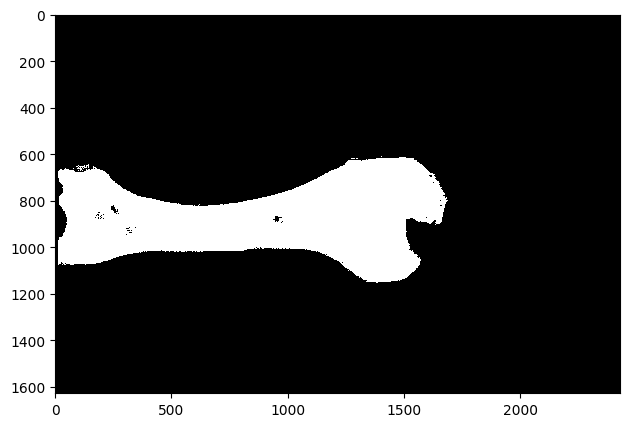

In [26]:
# back to original plan using PCA - https://automaticaddison.com/how-to-determine-the-orientation-of-an-object-using-opencv/
from math import atan2, cos, sin, sqrt, pi

 
def drawAxis(img, p_, q_, color, scale):
  p = list(p_)
  q = list(q_)
 
  ## [visualization1]
  angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
  hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
 
  # Here we lengthen the arrow by a factor of scale
  q[0] = p[0] - scale * hypotenuse * cos(angle)
  q[1] = p[1] - scale * hypotenuse * sin(angle)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
 
  # create the arrow hooks
  p[0] = q[0] + 9 * cos(angle + pi / 4)
  p[1] = q[1] + 9 * sin(angle + pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
 
  p[0] = q[0] + 9 * cos(angle - pi / 4)
  p[1] = q[1] + 9 * sin(angle - pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
  ## [visualization1]
 
def getOrientation(pts, img):
  ## [pca]
  # Construct a buffer used by the pca analysis
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]
 
  # Perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
 
  # Store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))
  ## [pca]
 
  ## [visualization]
  # Draw the principal components
  cv.circle(img, cntr, 3, (255, 0, 255), 2)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  drawAxis(img, cntr, p1, (255, 255, 0), 1)
  drawAxis(img, cntr, p2, (0, 0, 255), 5)
 
  angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
  ## [visualization]
 
  # Label with the rotation angle
  label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees"
  textbox = cv.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
  cv.putText(img, label, (cntr[0], cntr[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv.LINE_AA)
 
  return angle
 
 
 
 


 
# Load the image
img = cv.imread("C:\\Adaptix\\lamb_femur\\recon\\7.tiff")


if img is None:
  print("Error: File not found")
  exit(0)


gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

imshow(bw)
# Find all the contours in the thresholded image
contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)


""" 
# dict = {}
 
for i, c in enumerate(contours):
 
  # Calculate the area of each contour
  area = cv.contourArea(c)
 
  # Ignore contours that are too small (or too large -> would include 'or 5000000 < area:')
  if area < 3700: 
    continue
 
  # Draw each contour only for visualisation purposes
  cv.drawContours(img, contours, i, (0, 0, 255), 2)
 
  # Find the orientation of each shape
  getOrientation(c, img)
  print(getOrientation(c,img))
  # dict[area] = getOrientation(c,img)  # area corresponding to the angle --> later you want 
  # to pick the angle corresponding to the largest area maybe?

 
#imshow(img)

  
# Save the output image to the current directory
imwrite("C:\\Adaptix\\lamb_femur\\recon\\7OUT.tiff", img)
 """